# X-Ray Image Classification for COVID-19 - A Deep Learning Approach using Tensorflow
### Dataset Information

In our analysis we will be using the following dataset
* **COVID-19 RADIOGRAPHY DATABASE** 
<br> A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. The database consists of 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection), and 1345 Viral Pneumonia images.<br>
[Link to the dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) 

# **1.Importing Libraries**

In [1]:
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import cv2

# **2. Creating dataset**

In [2]:
img_height = 244 
img_width = 244
#create training and testing datasets
train_data = image_dataset_from_directory(
     '../input/covid19-radiography-database/COVID-19_Radiography_Dataset',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

#create training and testing datasets
val_data = image_dataset_from_directory(
     '../input/covid19-radiography-database/COVID-19_Radiography_Dataset',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 21165 files belonging to 4 classes.
Using 14816 files for training.
Found 21165 files belonging to 4 classes.
Using 6349 files for validation.


# **3.Exploratory Data Analysis**

In [3]:
class_names = train_data.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [4]:
labels = np.concatenate([labels for image, labels in train_data.take(1)], axis=0)

In [5]:
for images, labels in train_data.take(1):
    images = images.numpy()
    labels = labels.numpy()

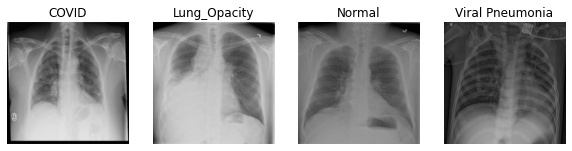

In [6]:
#visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    j  = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k].numpy().astype("uint8"))
                plt.title(class_names[j])
                plt.axis("off")
                break
        j = j+1

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training data class counts')

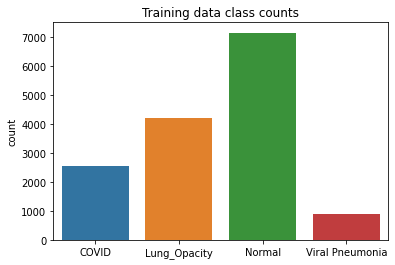

In [7]:
label_array_train = np.array([])
for images, labels in train_data.take(-1):  # only take first element of dataset, -1 takes all the elements of the dataset
    #numpy_images = images.numpy()
    numpy_labels =  labels.numpy()
    label_array_train = np.append(label_array_train,numpy_labels)

ax = sns.countplot(label_array_train,label = class_names)
ax.set_xticklabels(class_names)
ax.set_title('Training data class counts')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Validation data class counts')

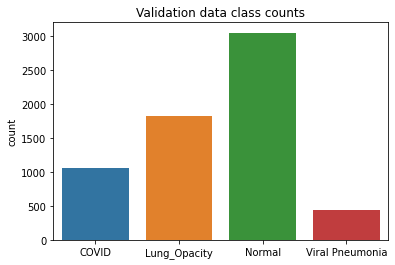

In [8]:
label_array_val = np.array([])
for images, labels in val_data.take(-1):  # only take first element of dataset, -1 takes all the elements of the dataset
    #numpy_images = images.numpy()
    numpy_labels =  labels.numpy()
    label_array_val = np.append(label_array_val,numpy_labels)

ax = sns.countplot(label_array_val,label = class_names)
ax.set_xticklabels(class_names)
ax.set_title('Validation data class counts')

# **4. Predictive Modeling**

### Using Convolutional Neural Networks

In [9]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()
    
    
    

In [10]:
def cnn_model(train_data,test_data, epochs,img_height,img_width):
#Building the model using Keras functional API
    print("----Building the model----")
    i = Input(shape=(img_height,img_width,3)) #defining input
    x = BatchNormalization()(i)
    x = Conv2D(32,3, activation= 'relu')(i) #adding convolution layers
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 
    

In [11]:
epochs = 20
r,model,n_epochs = cnn_model(train_data, val_data,epochs,img_height,img_width)

----Building the model----
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None

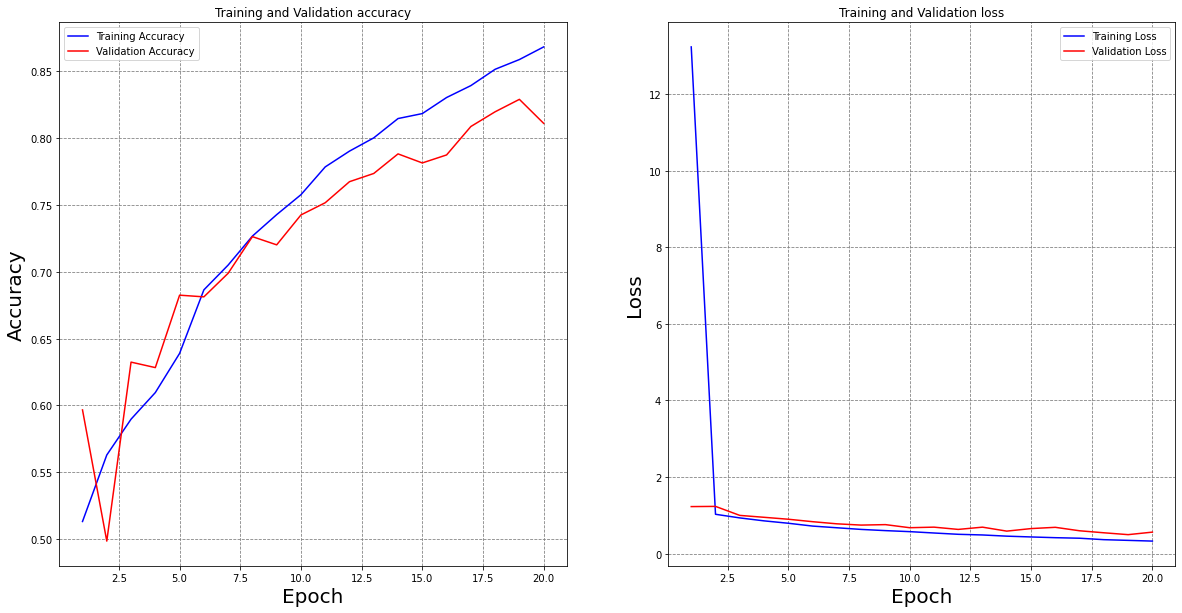

In [12]:
plotLearningCurve(r,n_epochs)

In [13]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 20s 98ms/step - loss: 0.5610 - accuracy: 0.8110
Test Accuracy using CNN: 81.10%
463/463 [==============================] - 47s 100ms/step - loss: 0.3087 - accuracy: 0.8834
Train Accuracy using CNN: 88.34%


### Using Resnet

In [14]:
def resnet_model(train_data,test_data, epochs,img_height,img_width):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = ResNet50(input_shape= (img_height,img_width,3), include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model=Model(inputs=base_model.input,outputs=out) 
    # model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [15]:
epochs = 10
r,model,n_epochs = resnet_model(train_data, val_data,epochs,img_height,img_width)

----Building the model----
94773248/94765736 [==============================] - 1s 0us/step
----Training the network----
Epoch 1/10
463/463 - 131s - loss: 0.2573 - accuracy: 0.9088 - val_loss: 0.4300 - val_accuracy: 0.8598

Epoch 00001: val_loss improved from inf to 0.43003, saving model to resnet_model.h5
Epoch 2/10
463/463 - 124s - loss: 0.1230 - accuracy: 0.9567 - val_loss: 0.2900 - val_accuracy: 0.8929

Epoch 00002: val_loss improved from 0.43003 to 0.29002, saving model to resnet_model.h5
Epoch 3/10
463/463 - 124s - loss: 0.0848 - accuracy: 0.9690 - val_loss: 0.3605 - val_accuracy: 0.8669

Epoch 00003: val_loss did not improve from 0.29002
Epoch 4/10
463/463 - 125s - loss: 0.0589 - accuracy: 0.9796 - val_loss: 0.4367 - val_accuracy: 0.8633

Epoch 00004: val_loss did not improve from 0.29002
Epoch 5/10
463/463 - 125s - loss: 0.0506 - accuracy: 0.9808 - val_loss: 0.7557 - val_accuracy: 0.7535

Epoch 00005: val_loss did not improve from 0.29002
Epoch 6/10
463/463 - 125s - loss: 0.032

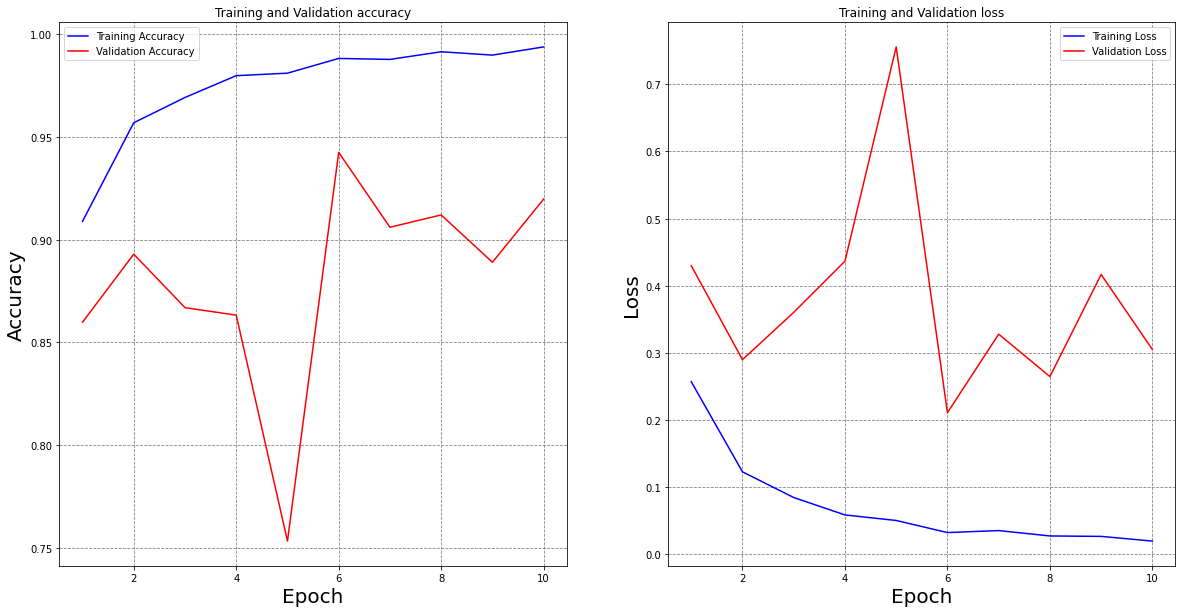

In [16]:
plotLearningCurve(r,n_epochs)

In [17]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using ResNet50: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using ResNet50: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 30s 147ms/step - loss: 0.3052 - accuracy: 0.9197
Test Accuracy using ResNet50: 91.97%
463/463 [==============================] - 71s 151ms/step - loss: 0.0851 - accuracy: 0.9672
Train Accuracy using ResNet50: 96.72%


### 